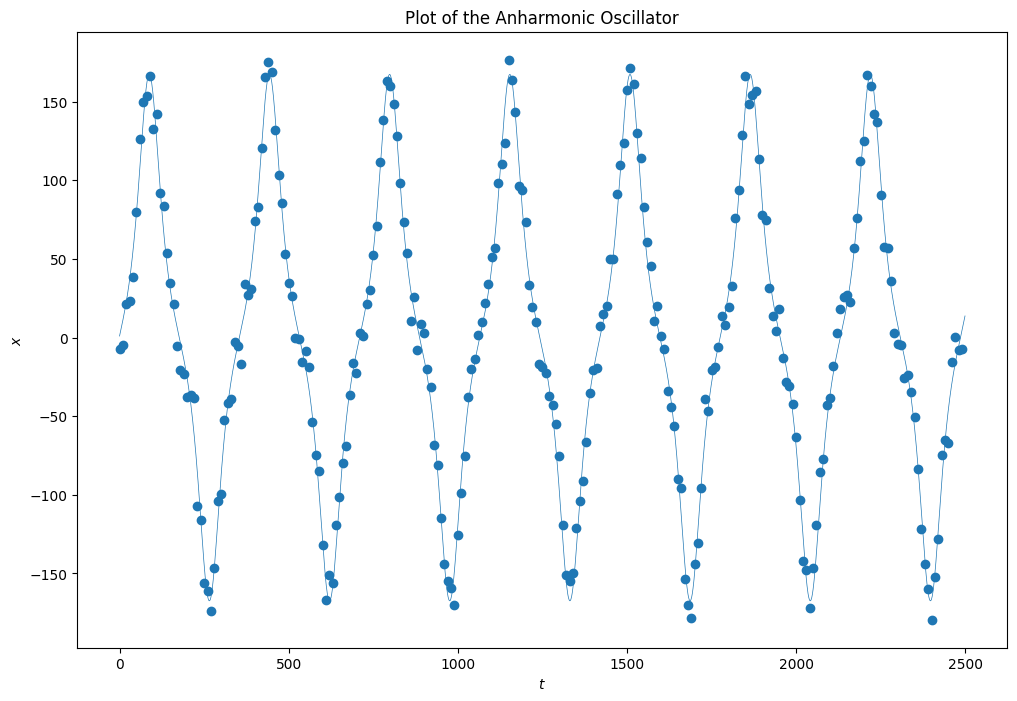

In [1]:
import matplotlib.pyplot as plt
import numpy as np

'''Discrete model approximating the anharmonic oscillator, this derivation comes from finite differencing of the continuous system'''
rng = np.random.default_rng()

sigma = 100 #standard deviation of the observation noise

x_0 = 0 
x_1 = 1

omega = 3.5 * 10**-2
lam = 3 * 10**-4

M = lambda u_k: np.array([
    [2 + omega**2 - lam**2 * u_k[0]**2, -1],
    [1,                               0]])

H = np.array([[1,0]])

N = 2500 #Number of time-points for which to simulate the system 

delta_t = 10

U = np.zeros((2,N)) #State is described by x_k and x_k-1
Y = np.zeros((1,N // delta_t)) #Observation is x_k 

R_o = sigma * np.array([[1]]) #observation noise
t_dis = np.arange(0,N,delta_t)

U[0,0] = x_1
U[1,0] = x_0

y_index = 0
for k in range(0,N-1): 
   U[:,k+1] = M(U[:,k]) @ U[:,k]

   if(k % delta_t == 0): 
    Y[:,y_index] = H @ U[:,k]
    y_index += 1


Y = Y + rng.multivariate_normal([0],R_o,size = np.size(Y)).squeeze()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot()
ax.plot(U[0, :],linewidth = 0.5)
ax.scatter(t_dis,Y.squeeze())
ax.set_ylabel("$x$")
ax.set_xlabel("$t$")
ax.set_title("Plot of the Anharmonic Oscillator")
plt.show()


In [2]:
'''EKF for the discrete system'''

def jac(y): 
    x1,x2 = y
    return np.array([[2 + omega**2 - 3 * (lam ** 2) * (x1**2), -1],
                     [1,                                        0]]) 


'''Extended Kalman Filter'''

R0 = np.eye(2)

m_false = np.array([1,0])

m_prior = m_false

'''The Kalman filter is used to estimate the state of the system.'''
R_prior = R0

K = R_prior@H.T@np.linalg.inv(H@R_prior@H.T + R_o)

m_post = np.zeros((2, len(t_dis)))
m_post[:, 0] = m_prior + K@(Y[:, 0] - H@m_prior)

R_post = np.zeros((2, 2, len(t_dis)))
R_post[:, :, 0] = R_prior - K@(H@R_prior@H.T + R_o)@K.T

# The Kalman filter is run for the rest of the time steps.
R_fwd = 0*np.eye(2)
for i_time in range(0, len(t_dis)-1):

    '''Simulation'''
    m_prior = m_post[:,i_time]
    for t in range(delta_t):
        m_prior = M(m_prior) @ m_prior

    R_prior = jac(m_prior)@R_post[:, :, i_time].squeeze()@jac(m_prior).T + R_fwd

    K = R_prior@H.T@np.linalg.inv(H@R_prior@H.T + R_o)

    m_post[:, i_time+1] = m_prior + K@(Y[:, i_time+1] - H@m_prior)

    R_post[:, :, i_time+1] = R_prior - K@(H@R_prior@H.T + R_o)@K.T


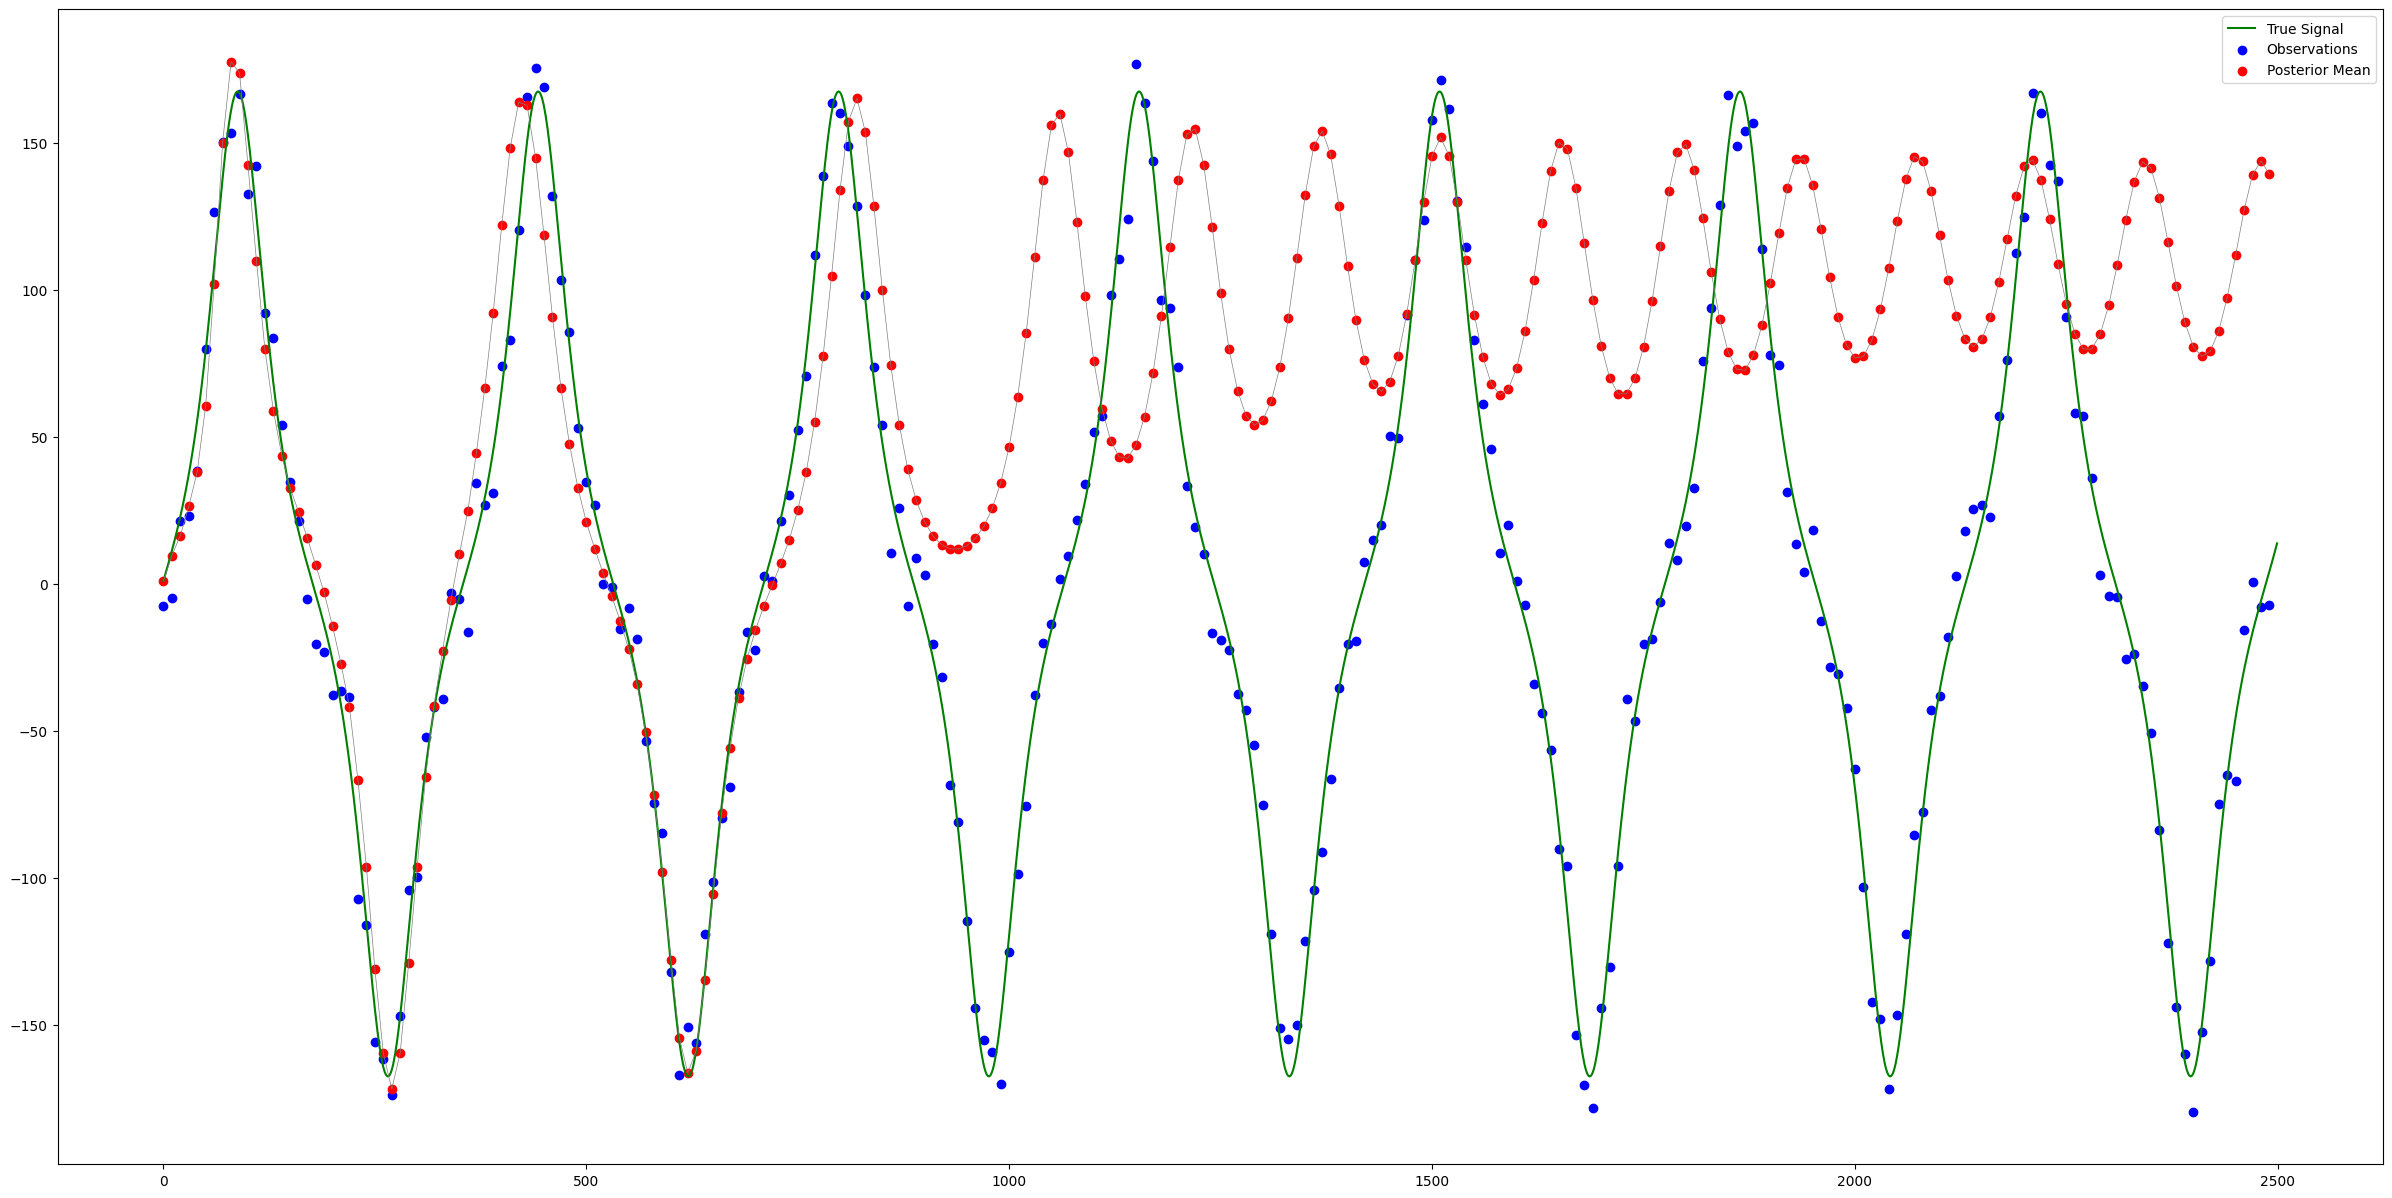

In [3]:
# Plot the first three variables
# The true signal is plotted in red
# The ensemble Kalman filter estimate is plotted in blue
fig = plt.figure(figsize=(30,15))

rows = 1
cols = 1

axes = fig.subplots(rows, cols)

axes.plot(U[0, :],color = 'green',label = 'True Signal')
axes.scatter(t_dis,Y.squeeze(),color = 'blue',label = 'Observations')
axes.scatter(t_dis,m_post[0,:],color = 'red',label = 'Posterior Mean')
axes.plot(t_dis,m_post[0,:],color = 'gray',linewidth=0.5)
axes.legend()
